In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
import task
from network import Model
import tools
from train import get_default_hp

from tools_lnd import calc_jacobian_at, vanilla_run_with_h0
from numpy import linalg as LA
from tools_lnd import eigenspectrum_axes

In [2]:
rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'retanh'
w_init = 'diag'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = str(1)
net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet'

task_list = ['dmcgo', 'dmcnogo', 'delaygo', 'dmsgo', 'delaydm1', 'delaydm2', 'multidelaydm']

In [3]:
for n in range(2):
    m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,str(n))

In [4]:
print(m)

/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1


In [6]:
###### EDIT THESE PARAMETERS ########
rule_trains = ['fdgo', 'fdanti','delaygo','delayanti']
l2w = -4
l2h = -5
l1w = 0
l1h = 0
n_rnn = 256 
activation = 'retanh'
init = 'randgauss'
model_n = 0
dt = 20
tau = 100
seed = 0

#############
s = '_'
rule_trains_str = s.join(rule_trains)
folder = str(model_n)

model_dir = os.path.join('data','discrete_v_contin_stability',activation,init,str(len(rule_trains))+'_tasks',
                       str(n_rnn)+'_n_rnn','l2_w'+str(-l2w)+'_h'+str(-l2h)+'_'+rule_trains_str,folder)

hp = { 'activation' : activation,
        'w_rec_init': init,
        'n_rnn': n_rnn,
        'l1_h': np.min([-l1h, 10**l1h]),
        'l2_h': np.min([-l2h, 10**l2h]),
        'l1_weight': np.min([-l1w, 10**l1w]),
        'l2_weight': np.min([-l2w, 10**l2w]),
        'l2_weight_init': 0,
        'n_eachring' : 2,
        'n_output' : 1+2,
        'n_input' : 1+2*2+20,
        'delay_fac' : 1,
        'sigma_rec': 0.05,
        'sigma_x': 0.1,
        'dt': dt,
        'tau' : tau,
        'use_separate_input': False}

tools.mkdir_p(model_dir)
max_steps = 0
ruleset = 'all'

# Network parameters
default_hp = get_default_hp(ruleset)
if hp is not None:
    default_hp.update(hp)
hp = default_hp
hp['seed'] = seed
hp['rng'] = np.random.RandomState(seed)
hp['rule_trains'] = rule_trains
hp['rules'] = hp['rule_trains']

rule_prob_map = dict()

# Turn into rule_trains format
hp['rule_probs'] = None
if hasattr(hp['rule_trains'], '__iter__'):
    # Set default as 1.

    rule_prob = np.array(
            [rule_prob_map.get(r, 1.) for r in hp['rule_trains']])
    hp['rule_probs'] = list(rule_prob/np.sum(rule_prob))

# Number of training iterations for each rule
if hasattr(max_steps, '__iter__'):
    rule_train_iters = max_steps
else:
    rule_train_iters = [len(r) * max_steps for r in rule_trains]

tools.save_hp(hp, model_dir)

# Build the model
with tf.device('gpu:0'):
    model = Model(model_dir, hp=hp)
    tools.save_hp(hp, model_dir)
    # Display hp
    for key, val in hp.items():
        print('{:20s} = '.format(key) + str(val))
    # Init and save    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        model.save()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
tau                  = 100
l2_weight_init       = 0
w_rec_init           = randgauss
alpha                = 0.2
target_cost          = 0
l2_h                 = 1e-05
n_eachring           = 2
rule_start           = 5
sigma_x              = 0.1
batch_size_train     = 64
target_perf          = 1.0
l1_h                 = 0
n_rnn                = 256
rules                = ['fdgo', 'fdanti', 'delaygo', 'delayanti']
n_output             = 3
p_weight_train       = None
learning_rate        = 0.001
save_name            = test
ruleset              = all
loss_type            = lsq
optimizer            = adam
rule_probs           = [0.25, 0.25, 0.25, 0.25]
n_input              =

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from data/discrete_v_contin_stability/tanh/randgauss/4_tasks/256_n_rnn/l2_w4_h5_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: data/discrete_v_contin_stability/tanh/randgauss/4_tasks/256_n_rnn/l2_w4_h5_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from data/discrete_v_contin_stability/tanh/randgauss/4_tasks/256_n_rnn/l2_w4_h5_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: data/discrete_v_contin_stability/tanh/randgauss/4_tasks/256_n_rnn/l2_w4_h5_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.0


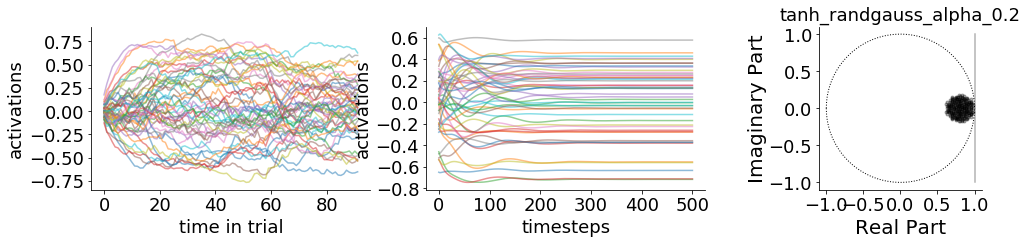

In [15]:
plot_stability(model_dir)

In [ ]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

In [19]:
activation = 'softplus'
rnn_type = 'LeakyRNN'
init = 'randgauss'
seed = 1
n_rnn = 256
l2w = -6
l2h = -6
l1w = 0
l1h = 0
rule_trains = all_rules = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
rule_trains_str = '_'.join(rule_trains)

m = os.path.join(p,'data','rnn','multitask','stepnet',rnn_type,activation,init,str(len(rule_trains))+'_tasks',
                str(n_rnn)+'_n_rnn','l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str,
                 str(seed))

In [30]:
hp

{u'activation': u'softplus',
 u'alpha': 0.2,
 u'batch_size_test': 8192,
 u'batch_size_train': 64,
 u'c_intsyn': 0,
 u'delay_fac': 1,
 u'dt': 20,
 u'in_type': u'normal',
 u'ksi_intsyn': 0,
 u'l1_h': -0.0,
 u'l1_weight': -0.0,
 u'l2_h': 1e-06,
 u'l2_weight': 1e-06,
 u'l2_weight_init': 0,
 u'learning_rate': 0.001,
 u'loss_type': u'lsq',
 u'n_eachring': 2,
 u'n_input': 25,
 u'n_output': 3,
 u'n_rep': 256,
 u'n_rnn': 256,
 u'n_rule': 20,
 u'num_ring': 2,
 u'optimizer': u'adam',
 u'p_weight_train': None,
 'rng': <mtrand.RandomState at 0x7f84b5c9aaa0>,
 u'rnn_type': u'LeakyRNN',
 u'rule_probs': [0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667],
 u'rule_start': 5,
 u'rule_trains': [u'fdgo',
  u'reactgo',


In [6]:
def plot_stability(m,rule = 'delaygo', epoch = 'stim1', trial_n = 0):

    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        hp = model.hp
        trial = generate_trials(rule, hp, mode='random', noise_on=False, batch_size =100, delay_fac =1)
        feed_dict = tools.gen_feed_dict(model, trial, hp)
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict)

    fig = plt.figure(figsize=(17, 3))

    # Plot during task
    ax1 = plt.subplot(1,3,1)
    plt.plot(h_tf[:,0,:50],alpha = .5)
    plt.xlabel('time in trial',fontsize = 18)
    plt.ylabel('activations',fontsize = 18)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    #Plot evolution of hidden state for extended time
    n_steps = 500
    x_t = np.matlib.repmat(trial.x[-1,trial_n,:],n_steps,1)
    h0 = h_tf[-1,trial_n,:]
    h_t = vanilla_run_with_h0(params, x_t, h0, hp)

    ax1 = plt.subplot(1,3,2)
    ax1.plot(h_t[:,:50],alpha = .5)
    plt.xlabel('timesteps',fontsize = 18)
    plt.ylabel('activations',fontsize = 18)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    #Plot eigenspectrum
    inputs = x_t[:1,:]
    state = h_t[-1:,:]

    dFdx = calc_jacobian_at(m,inputs,state,lesion_units = [])
    evals, _ = LA.eig(dFdx[0])

    xs = np.linspace(-1, 1, 1000)
    ys = np.sqrt(1 - xs**2)

    ax2 = plt.subplot(1,3,3)

    ax2.plot(evals.real,evals.imag,'.k',alpha = .3,markerfacecolor = 'k')
    ax2.plot(xs, ys,':k',linewidth = 1)
    ax2.plot(xs, -ys,':k',linewidth = 1)
    ax2.plot([1,1],[-1,1],'-k',alpha = .3)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    eigenspectrum_axes(epoch,ax2)
    ax2.set_aspect('equal')
    tit = hp['activation'] + '_' + hp['w_rec_init'] + '_alpha_' + str(hp['alpha'])
    plt.title(tit,fontsize = 18)

    save_dir = os.path.join(m,'stability_figs')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir,'eigenspec.png'))

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckp

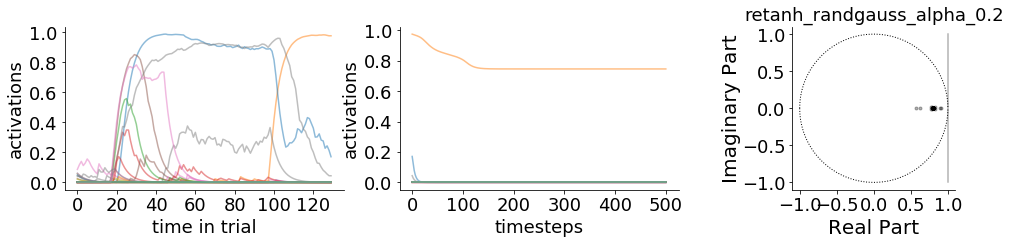

In [6]:
plot_stability(m)

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/l2_w6_h6_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/l2_w6_h6_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/l2_w6_h6_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


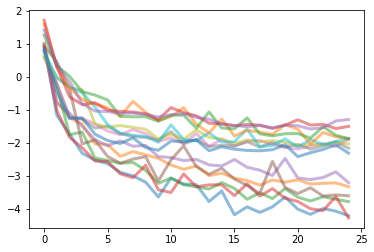

In [154]:
import json
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/l2_w6_h6_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/'

model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    hp = model.hp
task_list = hp['rule_trains']

fname = os.path.join(m, 'log.json')
with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    ax = fig.add_subplot(1,2,1)

    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',alpha = .5,linewidth = 3,label = rule)

    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost')

In [155]:
hp

{u'activation': u'tanh',
 u'alpha': 0.2,
 u'batch_size_test': 8192,
 u'batch_size_train': 64,
 u'c_intsyn': 0,
 u'delay_fac': 1,
 u'dt': 20,
 u'in_type': u'normal',
 u'ksi_intsyn': 0,
 u'l1_h': 0,
 u'l1_weight': 0,
 u'l2_h': 1e-06,
 u'l2_weight': 1e-06,
 u'l2_weight_init': 0,
 u'learning_rate': 0.001,
 u'loss_type': u'lsq',
 u'n_eachring': 2,
 u'n_input': 25,
 u'n_output': 3,
 u'n_rep': 256,
 u'n_rnn': 256,
 u'n_rule': 20,
 u'num_ring': 2,
 u'optimizer': u'adam',
 u'p_weight_train': None,
 'rng': <mtrand.RandomState at 0x7ffcd04ec0a0>,
 u'rnn_type': u'GRU',
 u'rule_probs': [0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667],
 u'rule_start': 5,
 u'rule_trains': [u'fdgo',
  u'reactgo',
  u'delaygo',
 